In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 backup		        Sharer.pw
 Backup		        TensorFlow-2.x-YOLOv3-master
'Colab Notebooks'      'Train_YoloV3 .ipynb'
 Fold_1		        yolo
'Getting started.pdf'   yolo_v2_tiny.ipynb
'My Drive'	        yolov3
 projects	        YOLOv3-Cloud-Tutorial-master
 ResNet34_v1.ipynb      YuuDrive


In [ ]:
ROWS = 256
COLS = 256
CHANNELS = 3
CLASSES = 2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size_tr = 32
batch_size_val = 32
input_size = (256,256,3)

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        featurewise_center=False,	# set input mean to 0 over dataset
        samplewise_center=False,	# set each sample mean to 0
        featurewise_std_normalization=False,	# divide inputs by std of dataset
        samplewise_std_normalization=False,	#divide each input by its std
        zca_whitening=False,	# apply ZCA whitening
        rotation_range=90,	# randomly roate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,	# randomly shift image horizontally (fraction of width)
        height_shift_range=0.1,	# randomly shift image vertically (fraction of height)
        horizontal_flip=True,	# randomly flip images horizontally
        vertical_flip=True	# randomly flip images vertically
        )

test_datagen = ImageDataGenerator()
                                  

train_generator = train_datagen.flow_from_directory(
        '/mydrive/Fold_1/train',  
        batch_size=batch_size_tr,
        shuffle=True,
        target_size=(256,256),
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/mydrive/Fold_1/validation',  
        batch_size=batch_size_val,
        target_size=(256,256),
        shuffle=True,
        class_mode='categorical')

Found 82 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [ ]:
import os
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback,LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.optimizers import Adam, SGD
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
import sys

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (3, 3), strides = (s,s),  padding='same',name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F2, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet34(input_shape = (256, 256, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    X = Sequential()

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    #X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64], stage=2, block='a')
    X = identity_block(X, 3, [64, 64], stage=2, block='b')
    X = identity_block(X, 3, [64, 64], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128], stage=3, block='b')
    X = identity_block(X, 3, [128, 128], stage=3, block='c')
    X = identity_block(X, 3, [128, 128], stage=3, block='d')


    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256], stage=4, block='b')
    X = identity_block(X, 3, [256, 256], stage=4, block='c')
    X = identity_block(X, 3, [256, 256], stage=4, block='d')
    X = identity_block(X, 3, [256, 256], stage=4, block='e')
    X = identity_block(X, 3, [256, 256], stage=4, block='f')


    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512], stage=5, block='b')
    X = identity_block(X, 3, [512, 512], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(0.5)(X)
    #X = Dense(128, activation='relu', name='fc2', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = Dropout(0.5)(X)

    
    X = Dense(classes, activation='softmax', name='fc5' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet34')

    return model

In [ ]:
model = ResNet34(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

In [ ]:
csv_logger = CSVLogger('/mydrive/Fold_1/ResNet34_SGD_LR_5_1FC_512_point5_dropout_v1.csv',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
import sys
global best_val_acc
global best_val_loss
best_val_loss = sys.float_info.max
best_val_acc = 0

#Saving the best model
checkpointer = ModelCheckpoint(filepath="/mydrive/Fold_1/ResNet34_best_weights_SGD_LR_5_1FC_512_point5_dropout_v1.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

#Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
def saveModel(epoch,logs):
  global best_val_loss
  global best_val_acc
  val_accuracy = logs['val_accuracy']
  val_loss = logs['val_loss']

  if val_accuracy > best_val_acc:
    best_val_acc = val_accuracy
    best_val_loss = val_loss
    model.save("/mydrive/Fold_1/ResNet34_best_weights_SGD_LR_5_1FC_512_point5_dropout_v1.hdf5")
  elif val_accuracy == best_val_acc:
    if val_loss < best_val_loss:
      best_val_loss=val_loss
      model.save("/mydrive/Fold_1/ResNet34_best_weights_SGD_LR_5_1FC_512_point5_dropout_v1.hdf5")

Lambdacallbacks = [LambdaCallback(on_epoch_end=saveModel)]

In [ ]:
history = model.fit_generator(train_generator,
                        epochs=2000,
                        validation_data=validation_generator,
                        verbose=1,
                        initial_epoch = 1000,
                        callbacks=[csv_logger,Lambdacallbacks])

Epoch 1001/2000
3/3 [==============================] - 2s 590ms/step - loss: 0.1984 - accuracy: 0.9268 - val_loss: 0.1905 - val_accuracy: 0.9643
Epoch 1002/2000
3/3 [==============================] - 2s 522ms/step - loss: 0.1836 - accuracy: 0.9390 - val_loss: 0.2032 - val_accuracy: 0.9643
Epoch 1003/2000
3/3 [==============================] - 2s 548ms/step - loss: 0.2243 - accuracy: 0.9146 - val_loss: 0.2092 - val_accuracy: 0.9643
Epoch 1004/2000
3/3 [==============================] - 2s 521ms/step - loss: 0.2356 - accuracy: 0.9268 - val_loss: 0.2111 - val_accuracy: 0.8929
Epoch 1005/2000
3/3 [==============================] - 2s 556ms/step - loss: 0.2326 - accuracy: 0.9268 - val_loss: 0.2467 - val_accuracy: 0.8929
Epoch 1006/2000
3/3 [==============================] - 2s 688ms/step - loss: 0.2379 - accuracy: 0.9024 - val_loss: 0.2881 - val_accuracy: 0.8929
Epoch 1007/2000
3/3 [==============================] - 2s 551ms/step - loss: 0.2569 - accuracy: 0.8415 - val_loss: 0.3169 - val_ac

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs = 1500, callbacks=[csv_logger])

In [ ]:
datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(
        '/mydrive/Fold_1/test',  
        batch_size=32,
        target_size=(256,256),
        shuffle=True,
        class_mode='categorical')

Found 28 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator)

1/1 [==============================] - 0s 2ms/step - loss: 1.1801 - accuracy: 0.7143


[1.1800949573516846, 0.7142857313156128]

In [ ]:
import pandas as pd
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

In [ ]:
#saving the weights
model.save_weights("/mydrive/Fold_1/ResNet34_weights_SGD_LR_5_1FC_512_point5_dropout_1000_epochs_71_v1.h5")

In [ ]:
model.load_weights("/mydrive/Fold_1/ResNet34_best_weights_SGD_LR_5_1FC_512_point5_dropout_v1.hdf5")

In [ ]:
import matplotlib.pyplot as plt

def append_history(history, h):
     '''
	This function appends the statistics over epochs
     '''
     try:
       history.history['loss'] = history.history['loss'] + h.history['loss']
       history.history['val_loss'] = history.history['val_loss'] + h.history['val_loss']
       history.history['accuracy'] = history.history['accuracy'] + h.history['accuracy']
       history.history['val_accuracy'] = history.history['val_accuracy'] + h.history['val_accuracy']
     except:
       history = h
                
     return history
            

def unfreeze_layer_onwards(model, layer_name):
    '''
        This layer unfreezes all layers beyond layer_name
    '''
    trainable = False
    for layer in model.layers:
        try:
            if layer.name == layer_name:
                trainable = True
            layer.trainable = trainable
        except:
            continue
    
    return model
            

def plot_performance(history):
    '''
	This function plots the train & test accuracy, loss plots
    '''
        
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.axis([0, 2000, 0.2, 0.8])
    plt.title('Accuracy v/s Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.axis([0, 2000, 0,1])
    plt.title('Loss v/s Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.tight_layout()
    plt.show()

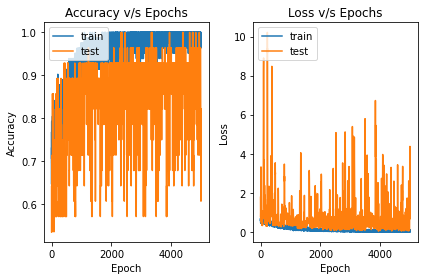

In [ ]:
plot_performance(history)

In [ ]:
np.save('/mydrive/Fold_1/my_history_ResNet_512x512_96_.npy',history.history)

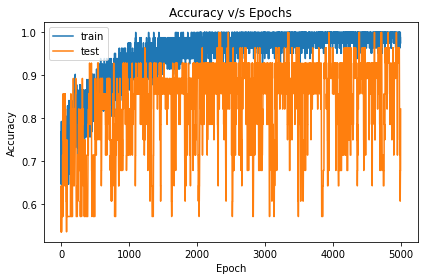

In [ ]:

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()

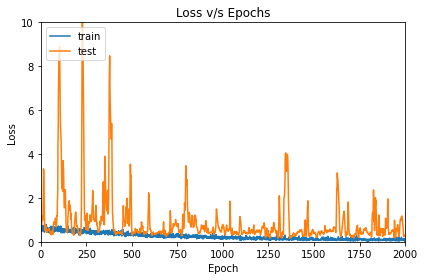

In [ ]:


plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.axis([0, 2000, 0,10])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plot_model(model, to_file='/mydrive/Fold_1/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
n=200
history.history['accuracy'] = np.convolve(history.history['accuracy'], np.ones((n,)) / n, mode = "valid")
history.history['val_accuracy'] = np.convolve(history.history['val_accuracy'], np.ones((n,)) / n, mode = "valid")

history.history['val_loss'] = np.convolve(history.history['val_loss'], np.ones((n,)) / n, mode = "valid")
history.history['loss'] = np.convolve(history.history['loss'], np.ones((n,)) / n, mode = "valid")

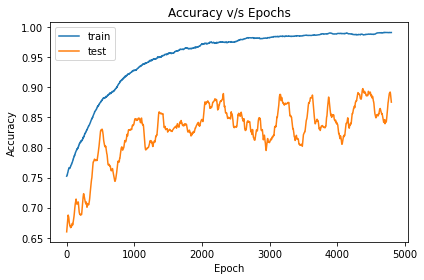

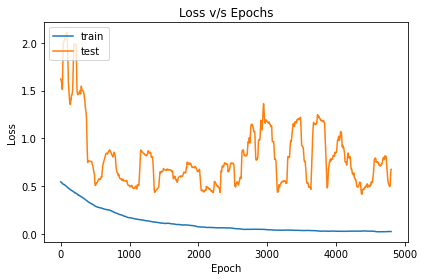

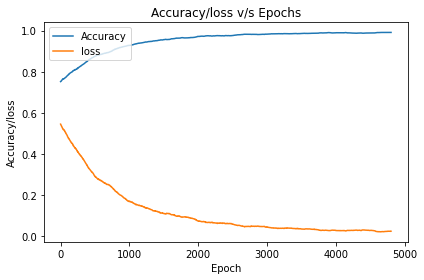

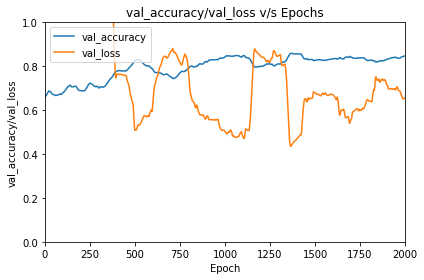

In [ ]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()



plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()



plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy/loss v/s Epochs')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'loss'], loc='upper left') 

plt.tight_layout()
plt.show()

plt.plot(history.history['val_accuracy'])

plt.plot(history.history['val_loss'])
plt.axis([0, 2000, 0,1])
plt.title('val_accuracy/val_loss v/s Epochs')
plt.ylabel('val_accuracy/val_loss')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'val_loss'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv('/mydrive/Fold_1/ResNet34_LR_5_1FC_256_point2_dropout_v1.csv')

history2 = df.to_dict(orient='list')

In [ ]:
n=200


history2['val_accuracy'] = np.convolve(history2['val_accuracy'], np.ones((n,)) / n, mode = "valid")
history2['accuracy'] = np.convolve(history2['accuracy'], np.ones((n,)) / n, mode = "valid")

history2['val_loss'] = np.convolve(history2['val_loss'], np.ones((n,)) / n, mode = "valid")
history2['loss'] = np.convolve(history2['loss'], np.ones((n,)) / n, mode = "valid")

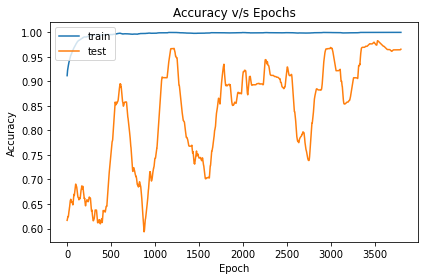

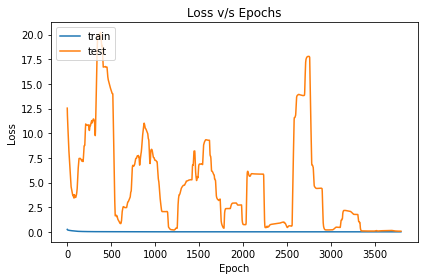

In [ ]:
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()

plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
## Now Predict
from os import listdir
from os.path import isfile, join
predict_dir_path='/mydrive/Fold_1/pred/pred/'
onlyfiles = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]
print(onlyfiles)

['bent_21.png', 'straight_31.png', 'straight_32.png', 'bent_46.png', 'bent_10.png', 'bent_28.png', 'straight_33.png', 'bent_70.png', 'bent_51.png', 'straight_3.png', 'straight_57.png', 'bent_38.png', 'bent_56.png', 'straight_13.png', 'straight_6.png', 'bent_7.png', 'straight_36.png', 'bent_1.png', 'bent_18.png', 'straight_21.png', 'bent_22.png', 'straight_27.png', 'straight_11.png', 'bent_71.png', 'straight_46.png', 'bent_73.png', 'bent_19.png', 'bent_66.png']


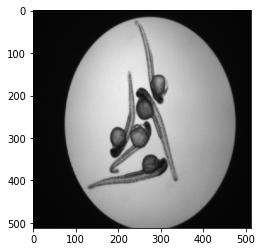

AttributeError: ignored

In [ ]:
# predicting images
from keras.preprocessing import image
neg_counter = 0 
pos_counter  = 0
fig=plt.figure()
for file in onlyfiles:
    img = image.load_img(predict_dir_path+file, target_size=(512, 512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #plt.subplot(4, 7, len(onlyfiles))
    plt.imshow(img)
    plt.show()
    
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size=32)
    #classes = classes[0][0]
    
    if classes == 0:
        print(file + ": " + 'negative')
        neg_counter += 1
    else:
        print(file + ": " + 'positive')
        pos_counter += 1

print("Total negative/bent fishes :",neg_counter)
print("Total positive/normal fishes :",pos_counter)